# Agent를 이용한 Corrective RAG

https://github.com/kyopark2014/langgraph-agent/blob/main/corrective-rag-agent.md

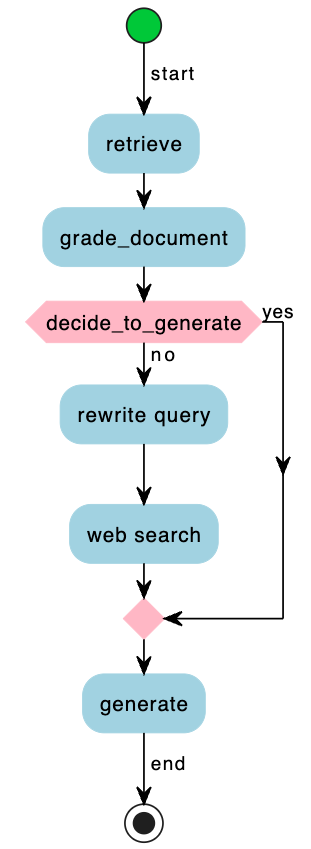

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

from langchain_community.embeddings import BedrockEmbeddings
embedding_model_id = "amazon.titan-embed-text-v2:0"
bedrock_embedding = BedrockEmbeddings(
    client=boto3_bedrock,
    region_name = bedrock_region,
    model_id = embedding_model_id
) 

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Corrective-RAG"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="이미지를 분석하기 위한 서비스에 대해 설명해줘."
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. 

주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 얼굴을 찾아내고 연령, 성별 등의 속성을 분석합니다.

텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 주제나 카테고리를 자동으로 분류합니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 필터링하는 데 사용됩니다.

이런 기능들을 활용하면 다양한 분야에서 이미지 데이터를 효율적으로 관리하고 인사이트를 얻을 수 있습니다. 하지만 아직 완벽하지 않아 오류가 발생할 수 있으므로 주의가 필요합니다. 이상으로 설명 드렸습니다.

'안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. \n\n주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 레이블을 붙입니다. 얼굴 인식은 이미지에서 얼굴을 찾아내고 연령, 성별 등의 속성을 분석합니다.\n\n텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 주제나 카테고리를 자동으로 분류합니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 필터링하는 데 사용됩니다.\n\n이런 기능들을 활용하면 다양한 분야에서 이미지 데이터를 효율적으로 관리하고 인사이트를 얻을 수 있습니다. 하지만 아직 완벽하지 않아 오류가 발생할 수 있으므로 주의가 필요합니다. 이상으로 설명 드렸습니다.'

In [12]:
!pip install faiss-cpu --quiet

In [13]:
# English URL
urls = [
    "https://aws.amazon.com/ko/blogs/tech/image-recommender-based-on-emotion/",
    "https://docs.aws.amazon.com/ko_kr/rekognition/latest/dg/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/textract/latest/dg/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html",
    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/glue-athena.html"
]

In [16]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores.faiss import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [17]:
doc_splits[0]

Document(metadata={'source': 'https://aws.amazon.com/ko/blogs/tech/image-recommender-based-on-emotion/', 'title': 'Amazon Rekognition과 Personalize를 이용하여 감정으로 이미지 추천하기 | AWS 기술 블로그', 'language': 'ko-KR'}, page_content='Amazon Rekognition과 Personalize를 이용하여 감정으로 이미지 추천하기 | AWS 기술 블로그\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n Skip to Main Content\n\n\n\n\n\nAmazon Web Services 홈 페이지로 돌아가려면 여기를 클릭하십시오.\n\n\n\n문의하기\n 지원\xa0 \n고객지원\n한국어\xa0\n내 계정\xa0\n\n\n\n\n 로그인\n\n\n  AWS 계정 생성 \n\n\n\n\n\n\n\n\n\nre:Invent\n제품\n솔루션\n요금\n설명서\n학습하기\n파트너 네트워크\nAWS Marketplace\n고객 지원\n이벤트\n자세히 알아보기 \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n 닫기 \n\n\n\nعربي\nBahasa Indonesia\nDeutsch\nEnglish\nEspañol\nFrançais\nItaliano\nPortuguês\n\n\n\n\nTiếng Việt\nTürkçe\nΡусский\nไทย\n日本語\n한국어\n中文 (简体)\n中文 (繁體)\n\n\n\n\n\n 닫기 \n\n내 프로필\nAWS Builder ID에서 로그아웃\nAWS Management Console\n계정 설정\n결제 및 비용 관리\n보안 자격 증명\nAWS Personal Health Dashboard\n\n\n\n 닫기 \n\n지원 센터\n

In [18]:
# Add to vectorDB
vectorstore = FAISS.from_documents(
    doc_splits,
    bedrock_embedding,
)
retriever = vectorstore.as_retriever()

In [19]:
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm_grader = chat.with_structured_output(GradeDocuments)

### Grade Prompt

In [20]:
# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [24]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "이미지를 분석하기 위한 서비스에 대해 설명해줘."
docs = retriever.invoke(question)

In [25]:
doc_txt = docs[1].page_content
doc_txt

'물체, 장면, 개념 감지 - 이미지에서 사물, 장면, 개념, 유명인을 감지하고 분류합니다.\n\n텍스트 감지 - 다양한 언어로 된 이미지에서 인쇄된 텍스트와 손으로 쓴 텍스트를 감지하고 인식합니다.\n\n안전하지 않은 콘텐츠 - 노골적이거나 부적절하고 폭력적인 콘텐츠와 이미지를 탐지하고 필터링합니다. 세분화된 안전하지 않은 콘텐츠 라벨을 탐지합니다.\n\n유명인 인식 - 정치인, 운동선수, 배우, 음악가 등 다양한 카테고리의 이미지 속 수만 명의 유명인을 인식합니다.\n\n얼굴 분석 - 성별, 나이, 감정 등의 얼굴 특성과 함께 얼굴을 감지, 분석 및 비교합니다. 사용 사례에는 사용자 확인, 카탈로그 작성, 인원 수 계산, 공공 안전 등이 포함될 수 있습니다.\n\n사용자 지정 레이블 - 사용자 지정 분류기를 만들어 로고, 제품, 문자 등 사용 사례에 맞는 개체를 탐지할 수 있습니다.\n\n이미지 속성 - 품질, 색상, 선명도, 대비와 같은 이미지 속성을 분석합니다.\n\n 비디오 분석:'

In [26]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### RAG Prompt

In [27]:
system = (
#"""Here is pieces of context, contained in <context> tags. Provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
"""다음의 <context> tag안의 참고자료를 이용하여 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.
                        
<context>
{context}
</context>""")
human = "{question}"
    
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
                   
rag_chain = prompt | chat

In [28]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

content='네, Amazon Rekognition은 이미지와 동영상을 분석하기 위한 딥러닝 기반의 서비스입니다. 주요 기능에 대해 설명드리겠습니다.\n\n1. 물체, 장면, 개념 감지: 이미지에서 사물, 장면, 개념, 유명인을 감지하고 분류합니다.\n\n2. 텍스트 감지: 다양한 언어로 된 이미지에서 인쇄된 텍스트와 손으로 쓴 텍스트를 감지하고 인식합니다.\n\n3. 안전하지 않은 콘텐츠 탐지: 노골적이거나 부적절하고 폭력적인 콘텐츠와 이미지를 탐지하고 필터링합니다.\n\n4. 유명인 인식: 정치인, 운동선수, 배우, 음악가 등 다양한 분야의 유명인을 인식합니다. \n\n5. 얼굴 분석: 성별, 나이, 감정 등의 얼굴 특성을 분석하고 얼굴을 감지 및 비교합니다.\n\n6. 사용자 지정 레이블: 로고, 제품, 문자 등 사용자 지정 분류기를 만들어 개체를 탐지할 수 있습니다.\n\n7. 이미지 속성 분석: 품질, 색상, 선명도, 대비 등의 이미지 속성을 분석합니다.\n\nAmazon Rekognition은 확장성과 보안을 갖추고 있으며 다른 AWS 서비스와 통합이 용이합니다. 사용한 만큼만 비용을 지불하는 저렴한 가격 정책을 가지고 있습니다.' additional_kwargs={'usage': {'prompt_tokens': 2104, 'completion_tokens': 563, 'total_tokens': 2667}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 2104, 'completion_tokens': 563, 'total_tokens': 2667}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-082ca62d-0b34-418f-bca6-12aa85e8

### ReWrite Prompt

In [29]:
class RewriteQuestion(BaseModel):
    """rewrited question that is well optimized for retrieval."""

    question: str = Field(description="The new question is optimized for web search")
    
structured_llm_rewriter = chat.with_structured_output(RewriteQuestion)

In [30]:
# Prompt 
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

In [31]:
question_rewriter = re_write_prompt | structured_llm_rewriter
question = "이미지를 분석하기 위한 서비스에 대해 설명해줘."
print(question_rewriter.invoke({"question": question}))

question='이미지 분석 서비스에 대해 자세히 알고 싶습니다. 어떤 기능과 장점이 있나요?'


## Graph state

In [32]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]

In [33]:
from langchain.schema import Document

def retrieve(state: GraphState):
    print("###### retrieve ######")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print("document[0]: ", documents[0])
    
    return {"documents": documents, "question": question}

In [34]:
def grade_documents(state: GraphState):
    print("###### grade_documents ######")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for doc in documents:
        score = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    print('len(docments): ', len(filtered_docs))
    print('web_search: ', web_search)
    
    return {"question": question, "documents": filtered_docs, "web_search": web_search}

In [35]:
def decide_to_generate(state: GraphState):
    print("###### decide_to_generate ######")
    question = state["question"]
    filtered_documents = state["documents"]
    web_search = state["web_search"]
    
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "rewrite"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [36]:
def generate(state: GraphState):
    print("###### generate ######")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    print('generation: ', generation.content)
    
    return {"documents": documents, "question": question, "generation": generation}

In [37]:
def rewrite(state: GraphState):
    pprint("###### rewrite ######")
    question = state["question"]

    # Prompt
    better_question = question_rewriter.invoke({"question": question})
    print("better_question: ", better_question.question)

    return {"question": better_question.question}

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [39]:
def web_search(state: GraphState):
    print("###### web_search ######")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    
    return {"question": question, "documents": documents}

### Build Graph

In [40]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("rewrite", rewrite)
workflow.add_node("websearch", web_search)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "rewrite": "rewrite",
        "generate": "generate",
    },
)
workflow.add_edge("rewrite", "websearch")
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

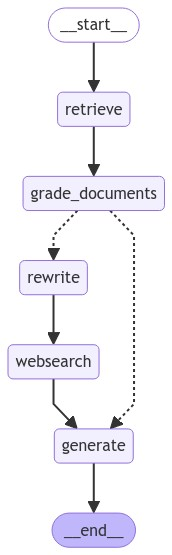

In [41]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [43]:
from pprint import pprint
inputs = {"question": "이미지를 분석하기 위한 서비스에 대해 설명해줘."}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='주요 기능
 이미지 분석:' metadata={'source': 'https://docs.aws.amazon.com/ko_kr/rekognition/latest/dg/what-is.html', 'title': 'Amazon Rekognition이란 무엇인가요? - Amazon Rekognition', 'description': '딥 러닝 이미지 분석 서비스인 Amazon Rekognition의 개요.', 'language': 'ko-KR'}
'Finished running: retrieve:'
###### grade_documents ######
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
len(docments):  4
web_search:  No
###### decide_to_generate ######
---DECISION: GENERATE---
'Finished running: grade_documents:'
###### generate ######
generation:  네, Amazon Rekognition은 딥러닝 기술을 활용한 이미지 및 비디오 분석 서비스입니다. 주요 기능에 대해 설명드리겠습니다.

1. 물체, 장면, 개념 감지: 이미지에서 사물, 장면, 개념, 유명인을 감지하고 분류할 수 있습니다.

2. 텍스트 감지: 다양한 언어로 된 이미지에서 인쇄된 텍스트와 손으로 쓴 텍스트를 감지하고 인식합니다.

3. 안전하지 않은 콘텐츠 탐지: 노골적이거나 부적절하고 폭력적인 콘텐츠와 이미지를 탐지하고 필터링할 수 있습니다.

4. 유명인 인식: 정치인, 운동선수, 배우, 음악가 등 다양한 분야의 유명인을 인식합니다.

5. 얼굴 분석: 성별, 나이, 감정 등의 얼굴 특성을 분석하고 

In [44]:
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='보여집니다. 사용자는 자신의 감정에 맞는 이미지를 선택하여 선호(like)를 표시할 수 있으며, 이때 생성된 상호작용(interaction) 이벤트를 상호작용 데이터셋으로 저장하여 추천 추론(inferece)을 향상시키는 데에 활용합니다.' metadata={'source': 'https://aws.amazon.com/ko/blogs/tech/image-recommender-based-on-emotion/', 'title': 'Amazon Rekognition과 Personalize를 이용하여 감정으로 이미지 추천하기 | AWS 기술 블로그', 'language': 'ko-KR'}
'Finished running: retrieve:'
###### grade_documents ######
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
len(docments):  0
web_search:  Yes
###### decide_to_generate ######
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
'###### rewrite ######'
better_question:  How does the AlphaCodium paper work?
'Finished running: rewrite:'
###### web_search ######
'Finished running: websearch:'
###### generate ######
generation:  죄송합니다. 제가 AlphaCodium 논문에 대해 잘 모르겠습니

In [45]:
inputs = {"question": "Aver의 TextRect는 무엇이지?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='앱에 문서 텍스트 감지 통합— Amazon Textract Textract는 간단한 API로 강력하고 정확한 분석을 사용할 수 있으므로 복잡하게 애플리케이션에 텍스트 감지 기능을 포함시킬 필요가 없습니다. Amazon Textract Textract를 사용하여 문서 텍스트를 감지하는 데는 컴퓨터 비전이나 딥 러닝에 관한 전문 지식이 필요하지 않습니다. Amazon Textract Text API를 사용하면 어떤 웹, 모바일 또는 연결된 장치의 애플리케이션에도 쉽게 텍스트 감지 기능을 통합할 수 있습니다.

확장 가능 문서 분석— Amazon Textract Textract를 사용하면 수백만 개의 문서에서 데이터를 신속하게 분석하고 추출하여 의사 결정을 가속화할 수 있습니다.' metadata={'source': 'https://docs.aws.amazon.com/ko_kr/textract/latest/dg/what-is.html', 'title': 'Amazon Textract Textract란 무엇인가? - Amazon Textract', 'description': '개요의 Amazon Textract 은 애플리케이션에 문서 텍스트 감지 및 분석 기능을 추가할 수 있도록 해 주는 서비스입니다.', 'language': 'ko-KR'}
'Finished running: retrieve:'
###### grade_documents ######
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
len(docments):  3
web_search:  Yes
###### decide_to_generate ######
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO Q